# Decompose Prediction

This tutorial demonstrate a tools to visualize time series components from Orbit models

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
from orbit.models.dlt import DLTMAP, DLTFull
from orbit.diagnostics.plot import plot_predicted_data,plot_predicted_components
from orbit.utils.dataset import load_iclaims

import warnings
warnings.filterwarnings('ignore')

## Data - Initial Claim

First, let's load the example data set. Here we used initial claims data from U.S. Employment and Training Administration. An initial claim is a claim filed by an unemployed individual after a separation from an employer. The claim requests a determination of basic eligibility for the Unemployment Insurance program. 

We will use following 5 columns from the dataset: 'week', 'claims', 'trend.unemploy', 'trend.filling' and 'trend.job'.

U.S. Employment and Training Administration, Initial Claims [ICNSA], retrieved from FRED, Federal Reserve Bank of St. Louis; https://fred.stlouisfed.org/series/ICNSA, January 3, 2021.

In [2]:
df = load_iclaims()
date_col='week'
response_col='claims'
df = df [['week', 'claims', 'trend.unemploy', 'trend.filling', 'trend.job']]

In [3]:
df.head()

week     claims  trend.unemploy  trend.filling  trend.job
0 2010-01-03  13.386595        0.168876      -0.328309   0.113033
1 2010-01-10  13.624218        0.168876      -0.204695   0.164326
2 2010-01-17  13.398741        0.185136      -0.302334   0.113033
3 2010-01-24  13.137549        0.152346      -0.204695   0.102451
4 2010-01-31  13.196760        0.083354      -0.252323   0.070016

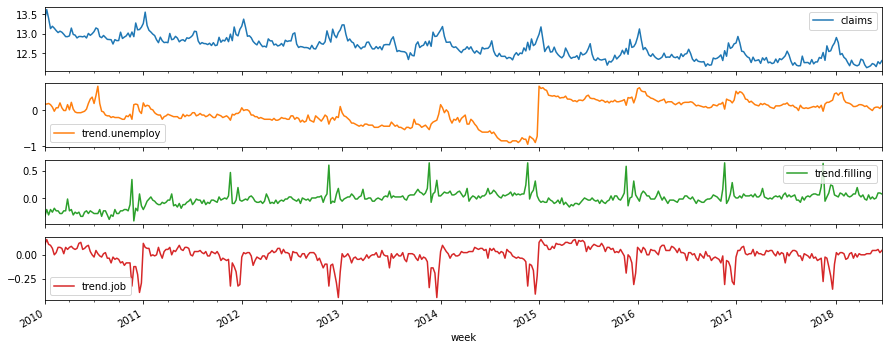

In [4]:
df_tmp = df.copy()
df_tmp.set_index('week', inplace = True) 
_ = df_tmp.plot(subplots=True, figsize=(15,6))

In orbit, **DLT** model is a variation of traditioal exponential smoothing models. The model results can be decomposed into **trend**, **seasonality** and **regression**. 

$$\hat{y}_t=\mu_t + s_t + r_t $$
Where $\mu_t$ is the trend, $s_t$ is the seasonality and $r_t$ is the regression. 

Here we will train the model dlt model and use `decompose=True` within `.predict()` to decompose the prediction. We transorformed the data to use the multiplicative form. After that, we can use `plot_predicted_components` to visualize the decomposition. This works for both MAP and MCMC estimation.

## MAP Estimation

First, we will train DLT model with 'claims' as the dependent vairable, and 'unemploy', 'filling' and 'job' as regressors. We will use data from 2010 to 2016 as in sample, and the rest as out-of-sample

In [5]:
train_df = df[df['week'] < '2017-01-01']
test_df = df[df['week'] >= '2017-01-01']

In [6]:
dlt = DLTMAP(
    response_col=response_col,
    regressor_col=['trend.unemploy', 'trend.filling', 'trend.job'],
    date_col=date_col,
    seasonality=52,
    seed=2020,
    global_trend_option='linear',
)
dlt.fit(train_df)

#### Plot Predicted Data

After fitting the model, we can plot in-sample predicted value with train response in the same figure. Here we showed claims data from 2010 to 2018.   

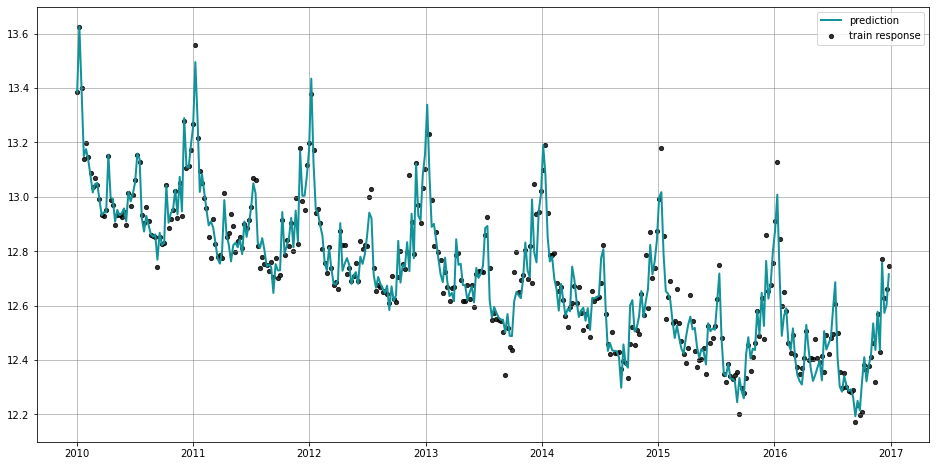

In [7]:
predicted_df = dlt.predict(df=train_df, decompose=True)
_ = plot_predicted_data(train_df, predicted_df, date_col=dlt.date_col, actual_col=dlt.response_col)

We can also plot future forecasting. Here we can predct the weekly claims after 2016

In [8]:
future_df = test_df[['week', 'trend.unemploy', 'trend.filling', 'trend.job']]

In [9]:
predicted_df = dlt.predict(df=future_df, decompose=True)

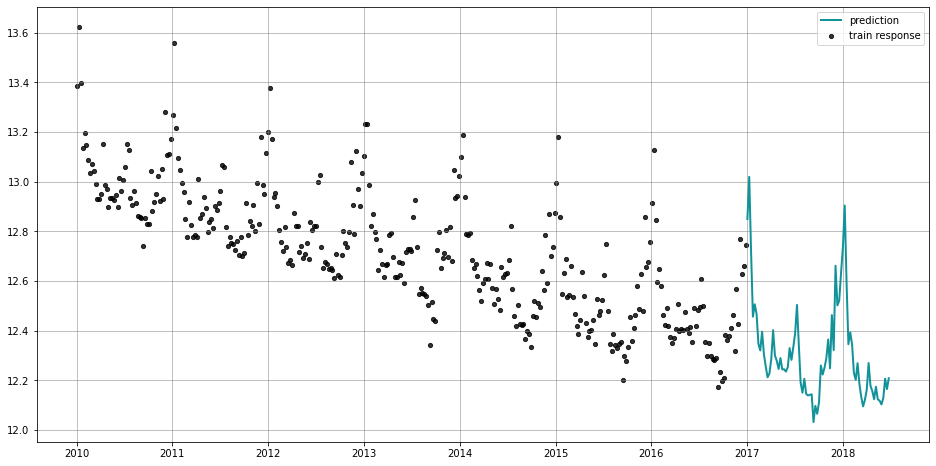

In [10]:
_ = plot_predicted_data(training_actual_df=train_df, predicted_df=predicted_df, 
                        date_col=dlt.date_col, actual_col=dlt.response_col)

#### Plot Predicted Components

To further understand the fitted model, we can decomponse the fitted value into trend, seasonlity and regression, and plot them on the same graph.  

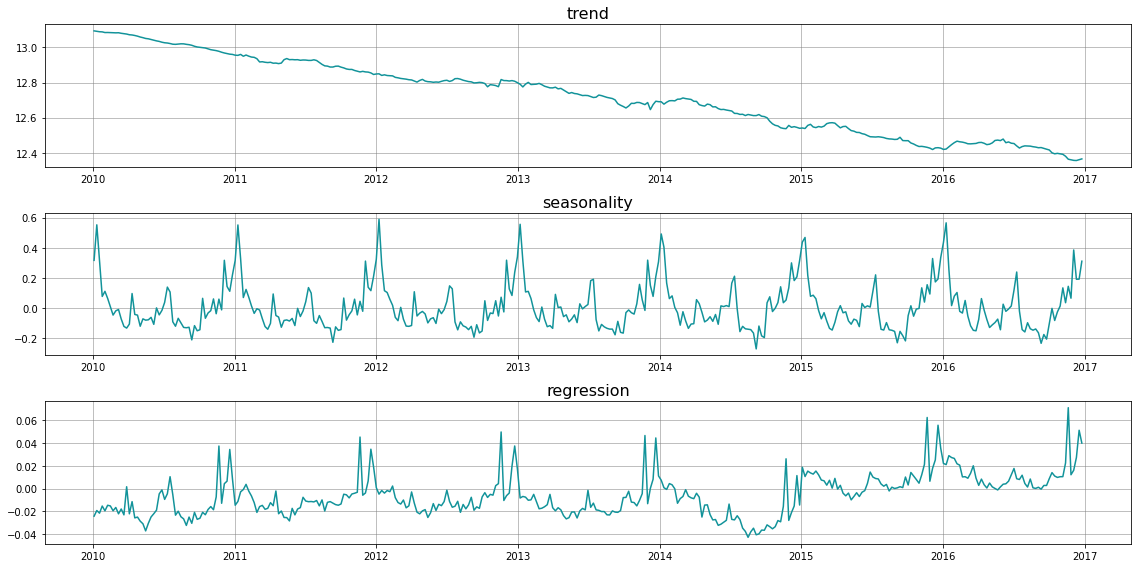

In [11]:
predicted_df = dlt.predict(df=train_df, decompose=True)
_ = plot_predicted_components(predicted_df, date_col)

The three componts are shown seperately. Multiplying them together will give us the total predicted value shown in the last section. We can clearly see a yearly decrease in trend, but similary yearly seasonality over the years. We can do the same for future forecasted value.

## MCMC Estimation

We can do the same thing for MCMC estimation.

In [12]:
dlt = DLTFull(
    response_col=response_col,
    regressor_col=['trend.unemploy', 'trend.filling', 'trend.job'],
    date_col=date_col,
    seasonality=52,
    seed=2020,
    prediction_percentiles=[5,95],
)
dlt.fit(train_df)

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


#### Plot Predicted Data

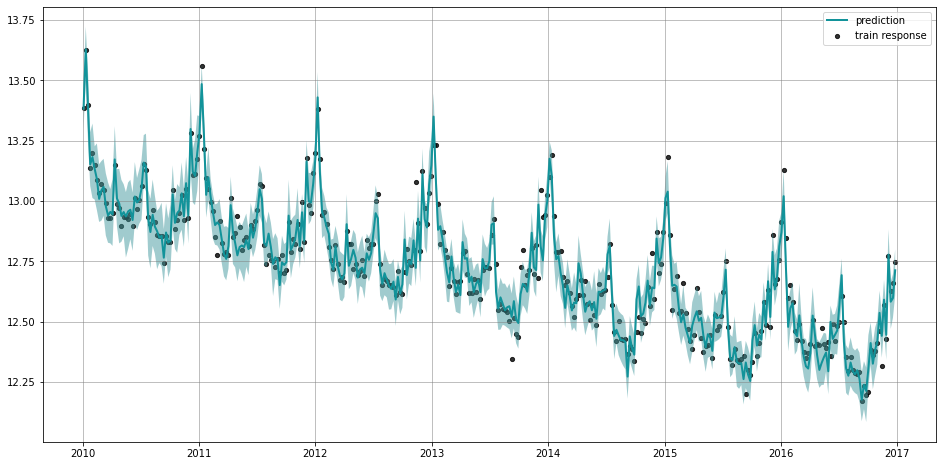

In [13]:
predicted_df = dlt.predict(df=train_df, decompose=True)
_ = plot_predicted_data(train_df, predicted_df, date_col=dlt.date_col, actual_col=dlt.response_col)

Predict the weekly claims after 2016

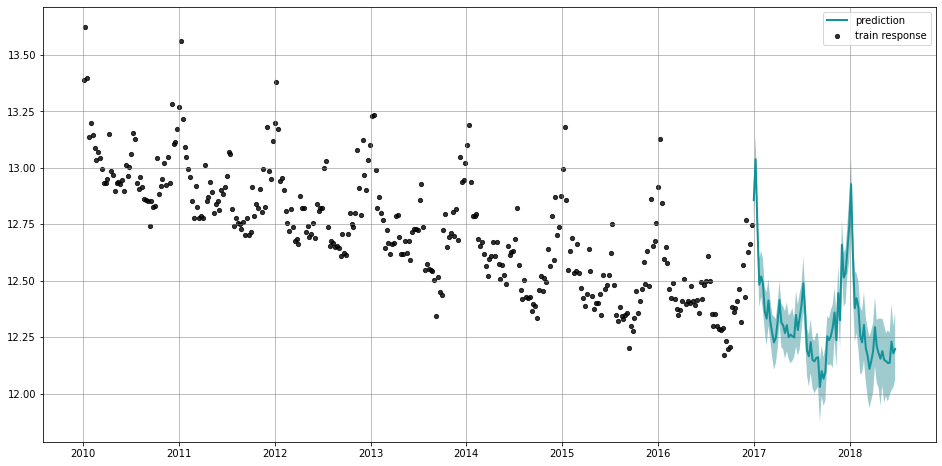

In [14]:
future_df = test_df[['week', 'trend.unemploy', 'trend.filling', 'trend.job']]
predicted_df = dlt.predict(df=future_df, decompose=True)
_ = plot_predicted_data(training_actual_df=train_df, predicted_df=predicted_df, 
                        date_col=dlt.date_col, actual_col=dlt.response_col)

#### Plot Predicted Components

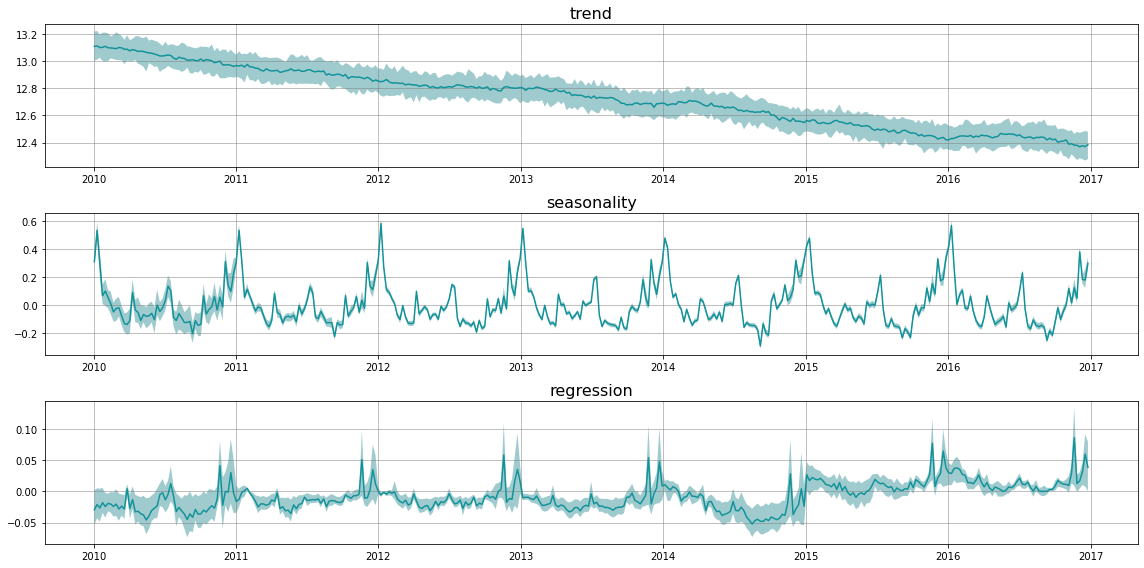

In [15]:
predicted_df = dlt.predict(df=train_df, decompose=True)
_ = plot_predicted_components(predicted_df, date_col)